In [1]:
import os, sys
import h5py
import numpy as np
import pandas as pd
import scipy
import math as m
import cmath
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from pprint import pprint
plt.switch_backend('TkAgg')


PROJECT_CWD = r"/workspace/"
sys.path.append(PROJECT_CWD)

from my_packages.neural_network.data_generators.magnetic_array_generator import RandomMagneticDipoleGenerator
from my_packages.neural_network.data_generators.iterator import DataIterator

# torch import 
import torch
from torch.utils.data import TensorDataset, DataLoader

print("cuda available: ", torch.cuda.is_available())
print("number of GPUs: ",torch.cuda.device_count())
print("I am currently using device number: ", torch.cuda.current_device())
print("the device object is: ", torch.cuda.device(0))
print("the device name is: ", torch.cuda.get_device_name(0))


# set all the seeds
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

cuda available:  True
number of GPUs:  1
I am currently using device number:  0
the device object is:  <torch.cuda.device object at 0x7f4bf1dfe0e0>
the device name is:  NVIDIA T600 Laptop GPU


In [51]:
# data parameters
resolution=(7,7)
field_res = (21,21)
xbounds = [-0.01, 0.01]
ybounds = [-0.01, 0.01]
dipole_height = 1e-3
substrate_thickness = 1.4e-2
substrate_epsilon_r = 4.4
dynamic_range = 10
probe_height = 0.3e-2
dipole_density = 0.2




rmg = RandomMagneticDipoleGenerator(
    resolution=resolution,
    xbounds=xbounds,
    ybounds=ybounds,
    dipole_height=dipole_height,
    substrate_thickness=substrate_thickness,
    substrate_epsilon_r=substrate_epsilon_r,
    dynamic_range=dynamic_range,
    probe_height=probe_height,
    field_res=field_res,
    dipole_density=dipole_density
    )

data_iterator = DataIterator(rmg, normalize=True)

# create the training data
N = 10000
inputs, target = data_iterator.generate_N_data_samples(N)

# create the test data
N_test = 1000
inputs_test, target_test = data_iterator.generate_N_data_samples(N_test)

# create the training and test datasets
train_and_valid_dataset = TensorDataset(torch.from_numpy(inputs).float(), torch.from_numpy(target).float())
print("train_dataset size: ", len(train_and_valid_dataset))
test_dataset = TensorDataset(torch.from_numpy(inputs_test).float(), torch.from_numpy(target_test).float())


train_dataset size:  4096


In [63]:
batch_size = 32

# split into training and validation sets
train_size = int(0.8 * len(train_and_valid_dataset))
val_size = len(train_and_valid_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_and_valid_dataset, [train_size, val_size])

print("train_dataset size: ", len(train_dataset))
print("val_dataset size: ", len(val_dataset))

# create the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

train_dataset size:  8000
val_dataset size:  2000


In [64]:
## INSPECTION

# %matplotlib inline
# for batch_ff, batch_tt in train_dataloader:
#     for ii in range(5):
#         rmg.plot_labeled_data(batch_ff[ii].numpy(), batch_tt[ii].numpy())
#     break   

In [96]:
from torch import nn
import torch.nn.functional as F

class FFN(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, loss_fn=F.mse_loss):
        super(FFN, self).__init__()
        self.fc1 = nn.Linear(in_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, out_size)
        self.loss_fn = loss_fn
    
    def forward(self, x):
        # reshape to linear array
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        out = self.fc2(x)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch
        targets = targets.view(targets.size(0), -1) # reshape to linear array
        out = self(inputs)
        loss = self.loss_fn(out, targets)
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        targets = targets.view(targets.size(0), -1) # reshape to linear array
        out = self(inputs)
        loss = self.loss_fn(out, targets)
        accuracy = self._accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_acc': accuracy}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
    

    def evaluate(self, val_loader):
        self.eval() # set to evaluation mode
        outputs = [self.validation_step(batch) for batch in val_loader]
        return self.validation_epoch_end(outputs)
    
    @staticmethod
    def _accuracy(out, targets, thresh=0.5):
        with torch.no_grad():
            # Convert output probabilities to binary values (0 or 1)
            out_binary = (out > thresh).float()

            # Calculate true positives, false positives and false negatives
            true_positives = (out_binary * targets).sum().item()
            false_positives = (out_binary * (1 - targets)).sum().item()
            false_negatives = ((1 - out_binary) * targets).sum().item()

            # Calculate precision and recall
            precision = true_positives / (true_positives + false_positives + 1e-8) # 1e-8 is added to avoid division by zero
            recall = true_positives / (true_positives + false_negatives + 1e-8) 

            # Calculate F1 score
            f1_score = 2 * (precision * recall) / (precision + recall + 1e-8) # 1e-8 is added to avoid division by zero
            
            return torch.tensor(f1_score)

In [112]:
in_size = field_res[0]*field_res[1]*2
out_size = resolution[0]*resolution[1]*2


hidden_size = 100
loss_fn = nn.BCEWithLogitsLoss()

model = FFN(in_size, hidden_size, out_size, loss_fn=loss_fn)
for t in model.parameters():
    print(t.shape)


torch.Size([100, 882])
torch.Size([100])
torch.Size([98, 100])
torch.Size([98])


In [113]:
# for images, labels in train_dataloader:
#     outputs = model(images)
#     labels = labels.view(labels.size(0), -1) # reshape to linear array
#     loss = F.binary_cross_entropy_with_logits(outputs, labels)
#     print('Loss:', loss.item())
#     break

# print('outputs.shape : ', outputs.shape)
# print('Sample outputs :\n', outputs[:2].data)

In [114]:
## use the GPU
print("the gpu is available: ", torch.cuda.is_available())

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True) 

# test the to_device function
device = get_default_device()
for images, labels in train_dataloader:
    print("before beign assigned - Device: ", images.device)
    images = to_device(images, device)
    print("after being assigned - Device: ", images.device)
    break

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
# wrap the dataloaders
train_dataloader = DeviceDataLoader(train_dataloader, device)
val_dataloader = DeviceDataLoader(val_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)

# test the wrapped dataloaders
for xb, yb in val_dataloader:
    print("xb.device: ", xb.device)
    print("yb: ", yb)
    break



the gpu is available:  True
before beign assigned - Device:  cuda:0
after being assigned - Device:  cuda:0
xb.device:  cuda:0
yb:  tensor([[[[0., 1., 0.,  ..., 1., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 1., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 0., 0., 1.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 1., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [1., 1., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 1., 1.,  ..., 0., 0., 1.],
          [0., 0., 0.,  ..., 0., 0., 1.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0.,

In [115]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train() # set to training mode
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = model.evaluate(val_loader)
        if (epoch) % 10 == 0:
            model.epoch_end(epoch, result)
        history.append(result)
    return history





model = FFN(in_size, hidden_size, out_size, loss_fn=loss_fn)
to_device(model, device)



FFN(
  (fc1): Linear(in_features=882, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=98, bias=True)
  (loss_fn): BCEWithLogitsLoss()
)

In [116]:
# create a dataset
loss_fn = nn.MSELoss()
learning_rate = 5e-2
n_iterations = 200

model = FFN(in_size, hidden_size, out_size, loss_fn=loss_fn)
to_device(model, device)
history = fit(n_iterations, learning_rate, model, train_dataloader, val_dataloader)

Epoch [0], val_loss: 0.0947, val_acc: 0.0000
Epoch [10], val_loss: 0.0829, val_acc: 0.0000
Epoch [20], val_loss: 0.0754, val_acc: 0.0000
Epoch [30], val_loss: 0.0687, val_acc: 0.0022
Epoch [40], val_loss: 0.0627, val_acc: 0.0646
Epoch [50], val_loss: 0.0574, val_acc: 0.2225
Epoch [60], val_loss: 0.0528, val_acc: 0.3972
Epoch [70], val_loss: 0.0488, val_acc: 0.5283
Epoch [80], val_loss: 0.0453, val_acc: 0.6157
Epoch [90], val_loss: 0.0423, val_acc: 0.6770
Epoch [100], val_loss: 0.0397, val_acc: 0.7234
Epoch [110], val_loss: 0.0374, val_acc: 0.7534
Epoch [120], val_loss: 0.0354, val_acc: 0.7757
Epoch [130], val_loss: 0.0337, val_acc: 0.7951
Epoch [140], val_loss: 0.0322, val_acc: 0.8112
Epoch [150], val_loss: 0.0309, val_acc: 0.8221
Epoch [160], val_loss: 0.0298, val_acc: 0.8305
Epoch [170], val_loss: 0.0288, val_acc: 0.8396
Epoch [180], val_loss: 0.0279, val_acc: 0.8451
Epoch [190], val_loss: 0.0271, val_acc: 0.8506


Test Loss: 0.0265


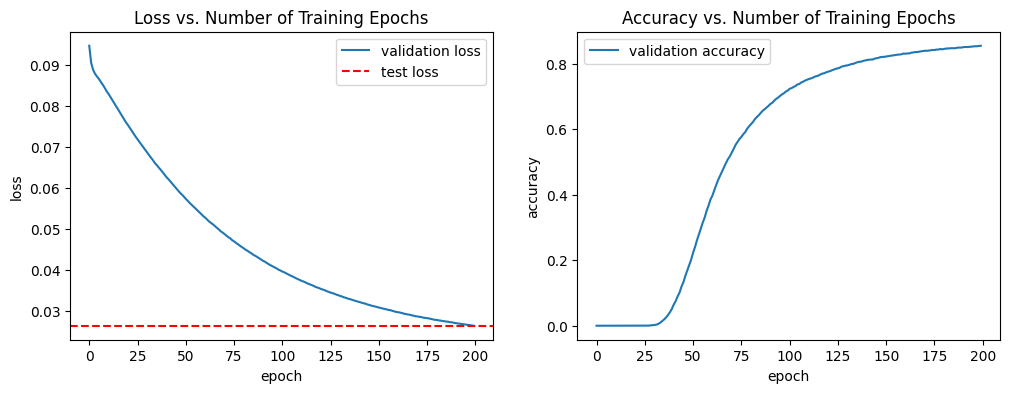

In [117]:
%matplotlib inline
import matplotlib.pyplot as plt

h = [x['val_loss'] for x in history]
acc = [x['val_acc'] for x in history]

to_device(model, 'cuda')

# Evaluate the model on the test set
with torch.no_grad():
    test_loss = 0.0
    for test_xb, test_yb in test_dataloader:
        test_yb = test_yb.view(test_yb.size(0), -1) # reshape to linear array
        model.eval()
        test_pred = model(test_xb)
        test_loss += loss_fn(test_pred, test_yb).item()
    
    test_loss /= len(test_dataloader)
    print('Test Loss: {:.4f}'.format(test_loss))

# Plot loss and validation loss
fig, (ax, ax1) = plt.subplots(1,2, figsize=(12,4))
ax.plot(h, label='validation loss')

ax.axhline(y=test_loss, color='r', linestyle='--', label='test loss')

ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss vs. Number of Training Epochs')
ax.legend()

ax1.plot(acc, label='validation accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy vs. Number of Training Epochs')
ax1.legend()

plt.show()

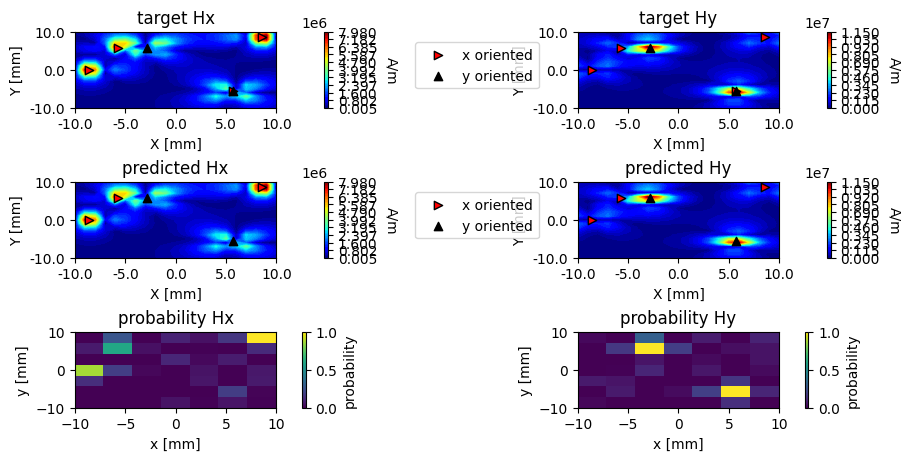

In [120]:
random_H, target = rmg.generate_labeled_data()
def predict(H, threshold=0.5, output_shape =None, renormalize_to_01=False):
    # normalize H
    min_value = np.min(H)
    max_value = np.max(H)
    H = (H - min_value) / (max_value - min_value)

    H = np.expand_dims(H.flatten(), axis=0)
    H = torch.from_numpy(H).float()
    with torch.no_grad():
        model.eval()
        to_device(model, "cpu")
        pred = model(H)
    pred = pred.numpy().squeeze()
    if output_shape is not None:
        pred = pred.reshape(output_shape)
    # transform to probabilities
    # clip to zero minimum
    if renormalize_to_01:
        max_value = np.max(pred)
        min_value = np.min(pred)
        prob_pred = (pred - min_value) / (max_value - min_value)
    else:
        prob_pred = pred

    binarized_pred = np.zeros_like(pred)
    binarized_pred[prob_pred > threshold] = 1
    pred = binarized_pred
    return pred, prob_pred

certainty = 0.5
prediction, pred_probability = predict(random_H, output_shape=(2,7,7), threshold=certainty)

fig, ax = plt.subplots(3,2, figsize=(9,4.5), constrained_layout=True)

# ax[1,0].pcolor(prediction[0])
rmg.plot_labeled_data(random_H, target, ax=(ax[0,0], ax[0,1]))
ax[0,0].set_title("target Hx")
ax[0,1].set_title("target Hy")
rmg.plot_labeled_data(random_H, prediction, ax=(ax[1,0], ax[1,1]))
ax[1,0].set_title("predicted Hx")
ax[1,1].set_title("predicted Hy")

x_grid, y_grid, _ = rmg.generate_r0_grid()[..., 0]
q1 = ax[2,0].pcolor(x_grid*1e3, y_grid*1e3, pred_probability[0], vmin=0, vmax=1)
q2 = ax[2,1].pcolor(x_grid*1e3, y_grid*1e3, pred_probability[1], vmin=0, vmax=1)
ax[2,0].set_title("probability Hx")
ax[2,1].set_title("probability Hy")
ax[2,0].set_xlabel("x [mm]")
ax[2,1].set_xlabel("x [mm]")
ax[2,0].set_ylabel("y [mm]")
ax[2,1].set_ylabel("y [mm]")
cbar = fig.colorbar(q1, ax=ax[2,0], ticks=[0, 0.5, 1], label="probability")
cbar = fig.colorbar(q2, ax=ax[2,1], ticks=[0, 0.5, 1], label="probability")

Text(0.5, 1.0, 'predicted Hy')

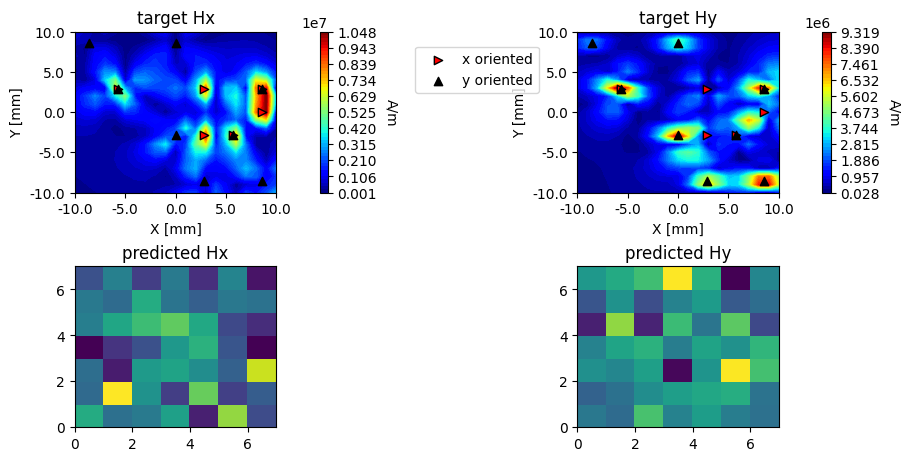

In [34]:
H0, target = rmg.generate_labeled_data()

min_value = np.min(H0)
max_value = np.max(H0)
H = (H0 - min_value) / (max_value - min_value)
H = np.expand_dims(H, axis=0)
H = torch.from_numpy(H).float()

to_device(model, "cpu")
with torch.no_grad():
    pred = model(H)
    pred = torch.sigmoid(pred)

pred = pred.numpy().squeeze()
pred = pred.reshape(2,7,7)

fig, ax = plt.subplots(2,2, figsize=(9,4.5), constrained_layout=True)
rmg.plot_labeled_data(H0, target, ax=(ax[0,0], ax[0,1]))
ax[0,0].set_title("target Hx")
ax[0,1].set_title("target Hy")
ax[1,0].pcolor(pred[0])
ax[1,1].pcolor(pred[1])
ax[1,0].set_title("predicted Hx")
ax[1,1].set_title("predicted Hy")